# Example CNN solution for the challenge

For this example, I started the CNN example notebook provided on the [summer's school github](https://github.com/WolfgangWaltenberger/oeawai/blob/master/CNN/CNN_example.ipynb), and adapted it to our challenge. It doesn't perform great, but it should be a good starting point for anyone wanting to tackle the challenge with a CNN.

This time we will need to use kaggle's GPU. On the right under settings you can turn the GPU on. 

In [1]:
from customdatasets import TrainDataset, TestDataset

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import csv
import librosa
import scipy as sc

In [3]:
# Hyperparameters
args = SimpleNamespace(batch_size=64, test_batch_size=64, epochs=3,
                       lr=0.01, momentum=0.5, seed=1, log_interval=200)
torch.manual_seed(args.seed)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [4]:
import numpy as np

toFloat = transforms.Lambda(lambda x: x / np.iinfo(np.int16).max)

trainDataset = TrainDataset("../input/oeawai/train/kaggle-train", transform=toFloat)
print(len(trainDataset))

testDataset = TestDataset("../input/oeawai/test/kaggle-test", transform=toFloat)
print(len(testDataset))

train_loader = torch.utils.data.DataLoader(trainDataset,
    batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(testDataset,
        batch_size=args.test_batch_size, shuffle=False) #Shuffle should be false!

269776
4096


# Data preprocessing

Let's define a way to transform the time-domain audio signals into time-frequency domain. It is always a good idea to plot the data to make sure the preprocessing is doing what we want it to do. 

(256, 252)
bass


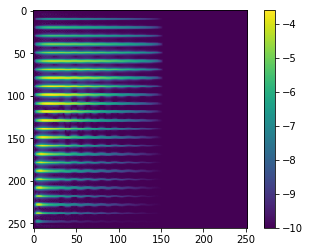

(256, 252)
bass


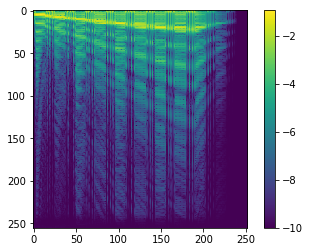

(256, 252)
bass


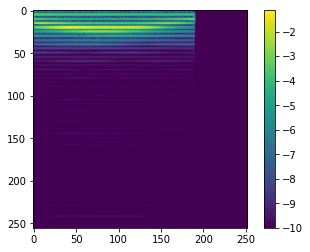

(256, 252)
bass


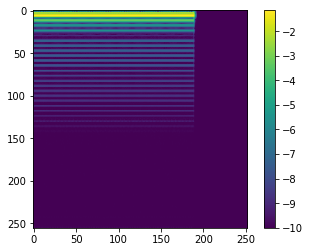

(256, 252)
keyboard


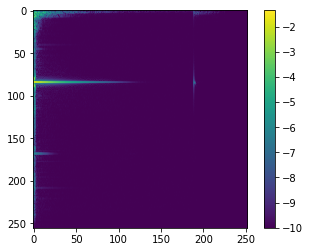

(256, 252)
keyboard


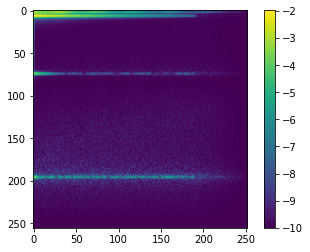

(256, 252)
bass


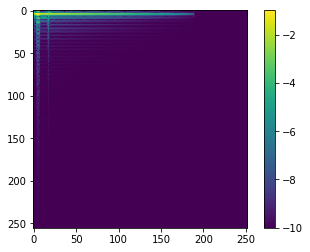

(256, 252)
brass


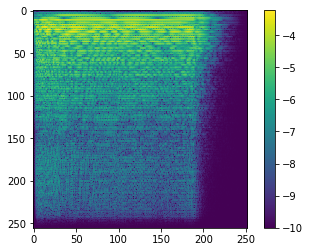

In [5]:
def logMagStft(numpyArray, sample_rate, n_fft):
    f, t, sx = sc.signal.stft(numpyArray, fs=sample_rate, nperseg=n_fft, noverlap=n_fft//2) 
    return np.log(np.abs(sx)+np.e**-10)

sample_rate = 16000
number_of_examples_to_plot = 8
n_fft = 510
spectrograms = np.zeros((number_of_examples_to_plot, n_fft//2+1, int(2*64000/n_fft)+2))
for samples, instrumentsFamily in train_loader:
    for index in range(number_of_examples_to_plot):
        spectrograms[index] = logMagStft(samples[index].numpy(), sample_rate, n_fft)
    family = trainDataset.transformInstrumentsFamilyToString(instrumentsFamily.numpy().astype(int))
    break # SVM is only fitted to a fixed size of data

import matplotlib.pyplot as plt
    
for i in range(number_of_examples_to_plot):
    print(spectrograms[i].shape)
    plt.imshow(spectrograms[i])
    print(family[i])
    plt.colorbar()
    plt.show()

# Net

In this class, you can modify the network's structure to try to improve the performance. 

In [6]:
# NN architecture (three conv and two fully connected layers)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.first_conv = nn.Conv2d(1, 20, 5, 1)
        self.second_conv = nn.Conv2d(20, 50, 5, 2)
        self.third_conv = nn.Conv2d(50, 50, 5, 2)
        self.fc1 = nn.Linear(50*6*6, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        n_fft = 510
    
        spectrograms = np.zeros((len(x), n_fft//2+1, int(2*64000/n_fft)+2))
        for index, audio in enumerate(x.cpu().numpy()):
            spectrograms[index] = logMagStft(audio, 16000, n_fft)
        
        x = torch.from_numpy(spectrograms[:, np.newaxis, :, :]).to(device).float()
        
        # x.size is (batch_size, 1, 256, 252)
        x = F.relu(self.first_conv(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.second_conv(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.third_conv(x))
        x = F.max_pool2d(x, 2, 2)
        # x.size is (batch_size, 50, 6, 6)
        x = x.view(-1, 6*6*50)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [7]:
# This function trains the model for one epoch
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [8]:
# This function evaluates the model on the test data
def test(args, model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        familyPredictions = np.zeros(len(test_loader.dataset), dtype=np.int)
        for index, samples in enumerate(test_loader):
            samples = samples.to(device)
            familyPredictions[index*len(samples):(index+1)*len(samples)] = model(samples).max(1)[1].cpu() # get the index of the max log-probability
    
    familyPredictionStrings = trainDataset.transformInstrumentsFamilyToString(familyPredictions.astype(int))

    with open('NN-submission-' +str(epoch)+'.csv', 'w', newline='') as writeFile:
        fieldnames = ['Id', 'Expected']
        writer = csv.DictWriter(writeFile, fieldnames=fieldnames, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        writer.writeheader()
        for index in range(len(testDataset)):
            writer.writerow({'Id': index, 'Expected': familyPredictionStrings[index]})
    print('saved predictions')

In [9]:
# Main
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=args.lr, 
                      momentum=args.momentum)

for epoch in range(1, args.epochs + 1):
    train(args, model, device, train_loader, optimizer, epoch)
    test(args, model, device, test_loader, epoch)


Train Epoch: 1 [0/269776 (0%)]	Loss: 2.342252
Train Epoch: 1 [12800/269776 (5%)]	Loss: 2.116509
Train Epoch: 1 [25600/269776 (9%)]	Loss: 1.919006
Train Epoch: 1 [38400/269776 (14%)]	Loss: 1.736433
Train Epoch: 1 [51200/269776 (19%)]	Loss: 1.630333
Train Epoch: 1 [64000/269776 (24%)]	Loss: 1.386003
Train Epoch: 1 [76800/269776 (28%)]	Loss: 1.150495
Train Epoch: 1 [89600/269776 (33%)]	Loss: 0.858910
Train Epoch: 1 [102400/269776 (38%)]	Loss: 0.862268
Train Epoch: 1 [115200/269776 (43%)]	Loss: 0.918642
Train Epoch: 1 [128000/269776 (47%)]	Loss: 1.235530
Train Epoch: 1 [140800/269776 (52%)]	Loss: 0.929968
Train Epoch: 1 [153600/269776 (57%)]	Loss: 1.031684
Train Epoch: 1 [166400/269776 (62%)]	Loss: 0.798232
Train Epoch: 1 [179200/269776 (66%)]	Loss: 0.684535
Train Epoch: 1 [192000/269776 (71%)]	Loss: 0.647360
Train Epoch: 1 [204800/269776 (76%)]	Loss: 0.683617
Train Epoch: 1 [217600/269776 (81%)]	Loss: 0.618022
Train Epoch: 1 [230400/269776 (85%)]	Loss: 0.521736
Train Epoch: 1 [243200/2697